In [4]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

### Dropout을 적용하여 Fully Connected Layer의 오버피팅 조정
* CNN은 일반적으로 Dense Layer보다는 파라미터수(weight 수) 작음
* 하지만 많은 Filter 들을 적용하고 이를  Fully Connected Layer로 연결 시 파라미터 수가 늘어남.
* Flatten() 이후 Dropout을 적용하여 특정 비율로 FC Layer 연결을 누락 적용.

In [7]:
def create_model():
    clear_session()
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(input_tensor)
    x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling2D(2)(x)

    x = Dropout(rate=0.5)(x)
    x = Flatten()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    output = Dense(10, activation='softmax')(x)
    model = Model(input_tensor, output)
    return model

In [8]:
# test
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                             

In [9]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 전체 6만개 데이터 중, 5만개는 학습 데이터용, 1만개는 테스트 데이터용으로 분리
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

def get_preprocessed_data(images, labels):

    # 학습과 테스트 이미지 array를 0~1 사이값으로 scale 및 float32 형 변형.
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)

    return images, labels

# 0 ~ 1사이값 float32로 변경하는 함수 호출 한 뒤 OHE 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    # OHE 적용
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 OHE 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2021):
    # 학습 및 테스트 데이터 세트를  0 ~ 1사이값 float32로 변경 및 OHE 적용.
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)

    # 학습 데이터를 검증 데이터 세트로 다시 분리
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)

    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels )


# Fashion MNIST 데이터 재 로딩 및 전처리 적용하여 학습/검증/데이터 세트 생성.

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('before reshape: ', train_images.shape, test_images.shape)

before reshape:  (60000, 28, 28) (10000, 28, 28)


### 입력 이미지는 배치를 포함하여 4차원이 되어야 함(즉 배치를 제외하면 3차원)
* Conv2D()는 입력으로 배치를 제외하고 3차원 입력이 되어야 함.
* 하지만 2차원으로 입력해도 Input(shape=(28, 28, 1)) 에서 3차원으로 변경함.
* 명확하게는 2차원 Grayscale이미지더라도 입력 numpy 이미지 배열에서 배치를 제외한 3차원 입력을 만들어 주는게 좋음.

In [10]:
train_images = np.reshape(train_images, (60000, 28, 28, 1))
test_images = np.reshape(test_images, (10000, 28, 28, 1))
print('after reshape: ', train_images.shape, test_images.shape)

after reshape:  (60000, 28, 28, 1) (10000, 28, 28, 1)


In [11]:
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
    get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.15, random_state=2023)

In [12]:
print(f'tr_images: ', tr_images.shape)
print(f'tr_oh_labels: ', tr_oh_labels.shape)
print(f'val_images: ', val_images.shape)
print(f'val_oh_labels: ', val_oh_labels.shape)
print(f'test_images: ', test_images.shape)
print(f'test_oh_labels: ', test_oh_labels.shape)

tr_images:  (51000, 28, 28, 1)
tr_oh_labels:  (51000, 10)
val_images:  (9000, 28, 28, 1)
val_oh_labels:  (9000, 10)
test_images:  (10000, 28, 28, 1)
test_oh_labels:  (10000, 10)


### 모델 생성과 compile

In [13]:
from tensorflow.keras.optimizers import Adam

# model 생성 및 optimizer, loss, metric 적용
model = create_model()
model.summary()


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                             

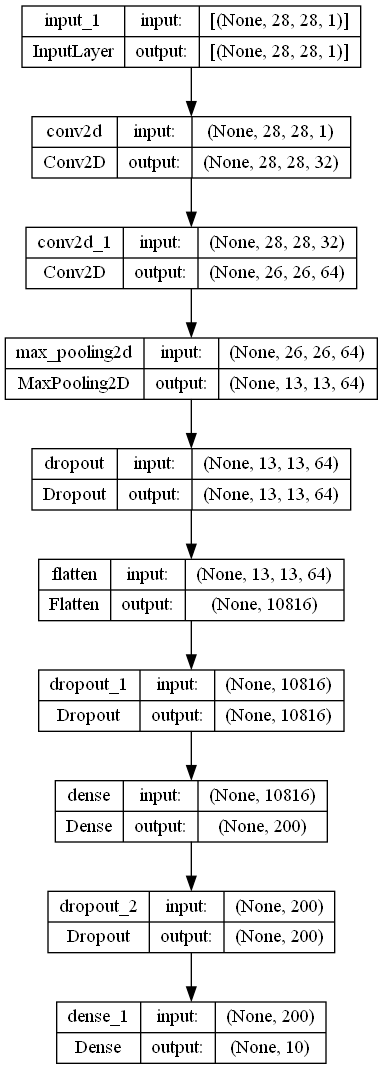

In [14]:
plot_model(model, show_shapes=True)

In [15]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=128, epochs=30, validation_data=(val_images, val_oh_labels))

Epoch 1/30
399/399 [==============================] - 9s 9ms/step - loss: 0.5125 - accuracy: 0.8153 - val_loss: 0.3306 - val_accuracy: 0.8849
Epoch 2/30
399/399 [==============================] - 3s 8ms/step - loss: 0.3474 - accuracy: 0.8733 - val_loss: 0.2824 - val_accuracy: 0.8977
Epoch 3/30
399/399 [==============================] - 3s 8ms/step - loss: 0.3025 - accuracy: 0.8889 - val_loss: 0.2531 - val_accuracy: 0.9071
Epoch 4/30
399/399 [==============================] - 3s 8ms/step - loss: 0.2721 - accuracy: 0.8993 - val_loss: 0.2373 - val_accuracy: 0.9126
Epoch 5/30
399/399 [==============================] - 3s 8ms/step - loss: 0.2530 - accuracy: 0.9062 - val_loss: 0.2227 - val_accuracy: 0.9157
Epoch 6/30
399/399 [==============================] - 3s 8ms/step - loss: 0.2353 - accuracy: 0.9119 - val_loss: 0.2142 - val_accuracy: 0.9228
Epoch 7/30
399/399 [==============================] - 3s 8ms/step - loss: 0.2218 - accuracy: 0.9177 - val_loss: 0.2111 - val_accuracy: 0.9204
Epoch 

### 모델 성능 평가

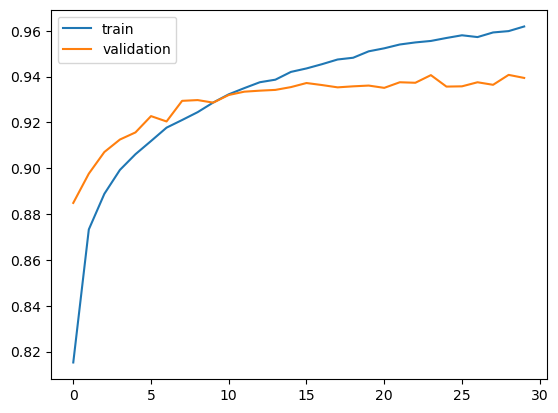

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.legend()
    plt.show()

show_history(history)

In [20]:
y_pred = model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 8ms/step - loss: 0.2026 - accuracy: 0.9325


In [21]:
print(f'y_pred: loss값 :', y_pred[0])
print(f'y_pred: accuracy값: ', y_pred[1])

y_pred: loss값 : 0.20259207487106323
y_pred: accuracy값:  0.9325000047683716
